# Import libraries

In [23]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/96/cf/a714a655266229b51eb2bda117f15275f12457887f165f3c1cc58ab502f1/scikit_learn-1.3.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/70/03/485f73046134400ea25d3cb178c5e6728f9b165f79d09638ecb44ee0e9b1/scipy-1.11.2-cp310-cp310-win_amd64.whl.metadata
     ---------------------------------------- 0.0/59.1 kB ? eta -:--:--
     ---------------------------------------- 59.1/59.1 kB ? eta 0:00:00
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbe

In [24]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import keras
import math
from keras import activations
from keras.layers import Dense , LSTM, Dropout
from keras.models import Sequential, load_model

# Loading train/test data with URL

In [6]:
id_col = ['id']
cycle_col = ['cycle']
setting_cols = ['setting1', 'setting2', 'setting3']
sensor_cols = ['sensor{}'.format(i) for i in range(1, 22)]
rul_col = ['RUL']
total_cols = id_col + cycle_col + setting_cols + sensor_cols + rul_col

## Loading the training data

In [7]:
def load_data(file_path):
    data = pd.read_csv(file_path, sep=" ", header=None)
    # Remove the columns 26, 27 because all rows are "None" values
    # print(data)
    data.drop([26, 27], axis=1, inplace=True)
    data.columns = id_col + cycle_col + setting_cols + sensor_cols
    return data

In [8]:
# Add train data with RUL
def add_train_RUL(data):
    df = data.copy()
    pd_RUL = df.groupby('id')['cycle'].max().reset_index()
    pd_RUL.columns = ['id', 'max_cycle']
    df = df.merge(pd_RUL, on=['id'], how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    df.drop(columns=['max_cycle'], inplace=True)
    return df[df['cycle'] > 0]

In [9]:
# Load train data
def load_training_data(dir_path, ID_dataset):
    training_path = os.path.join(dir_path, f'train_FD00{ID_dataset}.txt')
    data = load_data(training_path)
    training_data = add_train_RUL(data)
    return training_data

In [10]:
dir_path = "../../datasets/CMAPSS_JetEngine"
ID_dataset = 1 # Working with dataset FD001
df_train = load_training_data(dir_path, ID_dataset)
df_train

,id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [11]:
# Some types of measurement data are constant values, which cannot provide valuable information for the RUL prediction.
# Remove these columns ['setting3','sensor1','sensor5','sensor10','sensor16', 'sensor18','sensor19']

# Remove the properties that weakly correlate with the RUL ['id', 'setting1', 'setting2', 'sensor6']

# Remove the cycle as in this paper ['cycle']

df_train.drop(columns=['setting3','sensor1','sensor5','sensor10','sensor16', 'sensor18','sensor19', 'setting1', 'setting2', 'sensor6'], inplace=True)

In [12]:
df_train

,id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


## Loading the testing data

In [13]:
def load_testing_data(dir_path, ID_dataset):
    testing_path = os.path.join(dir_path, f'test_FD00{ID_dataset}.txt')
    data = load_data(testing_path)
    return data

In [14]:
dir_path = "../../datasets/CMAPSS_JetEngine"
ID_dataset = 1 # Working with dataset FD001
df_test = load_testing_data(dir_path, ID_dataset)
df_test_cp = df_test.copy()
test_max = df_test.groupby('id')['cycle'].max().reset_index()
test_max.columns = ['id', 'max']
df_test = df_test.merge(test_max, on=['id'], how='left')
# df_test.drop(columns=['setting3','sensor1','sensor5','sensor10','sensor16', 'sensor18','sensor19', 'id', 'setting1', 'setting2', 'sensor6', 'cycle'], inplace=True)
df_test

,id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,31
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,31
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,31
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,31
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,198
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,198
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,198
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,198


## Loading RUL testing data

In [15]:
RUL = pd.read_csv(f"{dir_path}/RUL_FD001.txt",sep=" ",header=None)
RUL.drop(RUL.columns[[1]], axis=1, inplace=True)
RUL

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


# Visualize the correlation matrix data

In [27]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(18,10)
plt.show()

NameError: name 'sns' is not defined

# Evaluation Metrics

In [16]:
# Equation (21)
def calculate_s_score(y_ground_truth, y_predicted_value, positive_exp_factor=10, negative_exp_factor=13):
    s_score = 0
    losses = y_predicted_value - y_ground_truth
    for loss in losses:
        if loss >= 0:
            s_score += math.exp(loss/positive_exp_factor) - 1
        else:
            s_score += math.exp(-loss/negative_exp_factor) - 1
    return s_score

In [17]:
def evaluate_model(y_ground_truth, y_predicted_value):
    """
    Return RMSE and s_score
    """
    rmse = mean_squared_error(y_ground_truth, y_predicted_value, squared=False)
    s_score = calculate_s_score(y_ground_truth, y_predicted_value)
    return rmse, s_score

# LSTM (Long Short-Term Memory)

## Data Preprocessing Functions

In [18]:
df_train

,id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [19]:
df_test

,id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,31
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,31
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,31
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,31
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,198
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,198
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,198
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,198


In [20]:
RUL

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [25]:
def process_data_lstm(training_data, testing_data, RUL_data):
    train_df = training_data.copy()
    truth_df = RUL_data.copy()
    
    # =======================================================
    # Training
    # =======================================================
    # MinMax normalization 
    cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL'])
    min_max_scaler = MinMaxScaler()

    norm_train_df = pd.DataFrame(
        min_max_scaler.fit_transform(train_df[cols_normalize]),
        columns=cols_normalize,
        index=train_df.index,
    )    
    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns = train_df.columns)
    print("train_df >> ",train_df.shape)

    # =======================================================
    # Testing
    # =======================================================
    # MinMax normalization

    # test_df = testing_data.drop(columns=['setting1', 'setting2', 'sensor6', 'max'])
    test_df = testing_data.drop(columns=['setting3','sensor1','sensor5','sensor10','sensor16', 'sensor18','sensor19', 'setting1', 'setting2', 'sensor6', 'max'])
    # 'setting3','sensor1','sensor5','sensor10','sensor16', 'sensor18','sensor19', 'id', 'setting1', 'setting2', 'sensor6', 'cycle'
    norm_test_df = pd.DataFrame(
        min_max_scaler.fit_transform(test_df[cols_normalize]),
        columns=cols_normalize,
        index=test_df.index
    )
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)
    test_df['id'] = test_df['id'].astype('int64')
    test_df['cycle'] = test_df['cycle'].astype('int64')
    # We can use ground truth dataset to generate labels for the test data.
    rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()    
    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)
    # Generate RUL for the test data
    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle']
    test_df.drop(columns=['max'], axis=1, inplace=True)
    print("train_df >> ", test_df.shape)

    # Generate window length
    WINDOW_LENGTH = 50
    def generate_sequences(id_df, window_length, window_cols):
        data_matrix = id_df[window_cols].values
        num_elements = data_matrix.shape[0]

        for start, stop in zip(range(0, num_elements-window_length), range(window_length, num_elements)):
            yield data_matrix[start:stop, :]
        # for start, stop in zip(range(0, nu))
    
    # Pick up feature columns, get all feature except RUL
    window_cols = list(test_df.columns[:-1])
    # id_df = train_df[train_df['id'] == 1]
    # val=list(generate_sequences(id_df, window_length=WINDOW_LENGTH, window_cols=window_cols))

    # Generator for the sequences
    windows_extraction = (list(generate_sequences(train_df[train_df['id']==id], window_length=WINDOW_LENGTH, window_cols=window_cols)) 
                        for id in train_df['id'].unique())

    windows_array = np.concatenate(list(windows_extraction)).astype(np.float32)
    print(f"TIME WINDOW EXTRACTION: {windows_array.shape}")


    def generate_labels(id_df, window_length, labels='RUL'):
        data_matrix = id_df[[labels]].values
        num_elements = data_matrix.shape[0]

        return data_matrix[window_length:num_elements, :]

    label_gen = list(generate_labels(train_df[train_df['id']==id], WINDOW_LENGTH, 'RUL') for id in train_df['id'].unique())
    labels_array = np.concatenate(label_gen).astype(np.float32)
    print(f"LABEL EXTRACTION: {labels_array.shape}")
    return windows_array, labels_array, test_df, WINDOW_LENGTH, window_cols

In [26]:
from sklearn.preprocessing import MinMaxScaler
windows_array, labels_array, test_df, WINDOW_LENGTH, window_cols = process_data_lstm(df_train, df_test, RUL)

train_df >>  (20631, 17)
train_df >>  (13096, 17)
TIME WINDOW EXTRACTION: (15631, 50, 16)
LABEL EXTRACTION: (15631, 1)


In [28]:
labels_array[-1]

array([0.], dtype=float32)

## LSTM architecture

In [42]:
def train(windows_array, labels_array, WINDOW_LENGTH):
    number_features = windows_array.shape[2]
    number_output = labels_array.shape[1]

    # LSTM
    model = Sequential()
    model.add(
        LSTM(
            input_shape=(WINDOW_LENGTH, number_features),
            units=100,
            return_sequences=True
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            units=50,
            return_sequences=False
        )
    )
    model.add(Dropout(0.2))
    model.add(Dense(units=number_output, activation='relu'))
    model.compile(loss="mean_squared_error", optimizer='Adam', metrics=['mae'])

    print(model.summary())

    history = model.fit(windows_array, labels_array, epochs=60, batch_size=256, validation_split=0.05, verbose=2)

    print(history.history.keys())
    return model, history

In [43]:
model, history = train(windows_array, labels_array, WINDOW_LENGTH)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           46800     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 77051 (300.98 KB)
Trainable params: 77051 (300.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
59

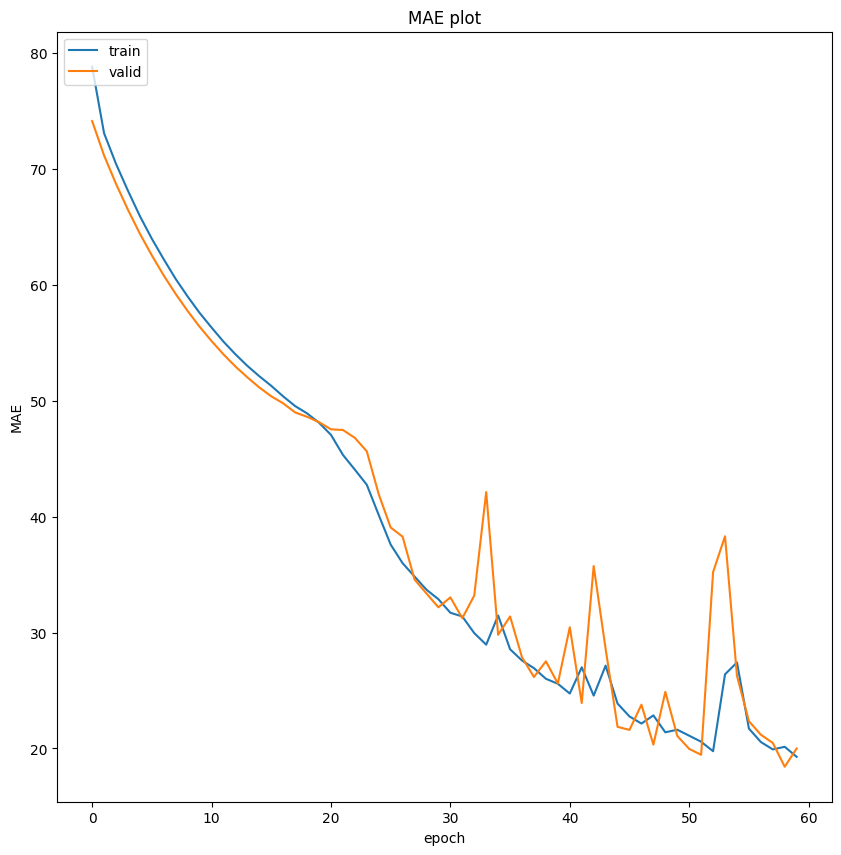

In [47]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE plot')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [152]:
def evaluate_lstm(test_df, model, WINDOW_LENGTH, window_cols):

    # we pick the last window for each id in the test_data
    last_sequences_test = []
    for id in test_df['id'].unique():
        if len(test_df[test_df['id'] == id]) >= WINDOW_LENGTH:
            last_sequence = test_df[test_df['id'] == id][window_cols].values[-WINDOW_LENGTH:]

            last_sequences_test.append(last_sequence)
    # return last_sequences_test
    last_sequences_test = np.asarray(last_sequences_test).astype(np.float32)
    # Select labels for the test data
    y_mask = [len(test_df[test_df['id']==id]) >= WINDOW_LENGTH for id in test_df['id'].unique()]
    last_labels_test = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
    last_labels_test = last_labels_test.reshape(last_labels_test.shape[0], 1).astype(np.float32)


    y_pred_test = model.predict(last_sequences_test)
    y_true_test = last_labels_test

    
    rmse, s_score = evaluate_model(y_true_test, y_pred_test)
    print("RMSE = ", rmse)
    print("S_Score = ", s_score)

    return y_pred_test, y_true_test

In [154]:
y_pred_test, y_true_test = evaluate_lstm(test_df, model, WINDOW_LENGTH, window_cols)

3/3 [==============================] - 0s 12ms/step
RMSE =  27.226444
S_Score =  1742.726811209522


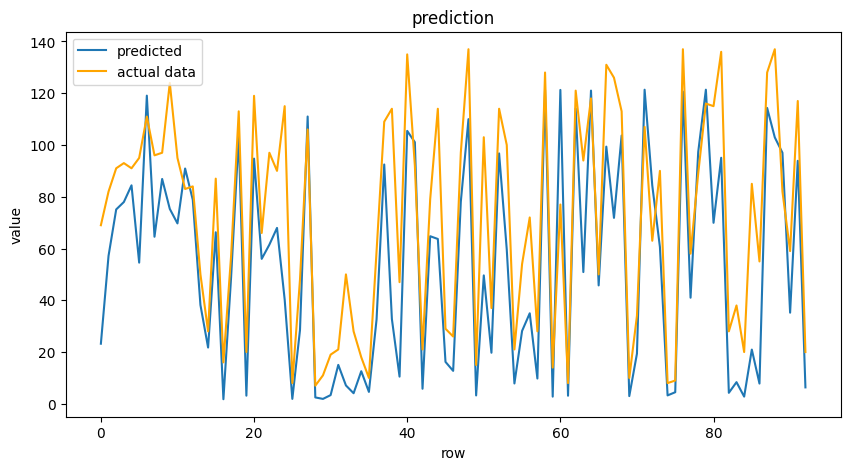

In [155]:
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test)
plt.plot(y_true_test, color="orange")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

In [101]:
test_df['id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)